In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder



C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Pandas version:", pd.__version__)
from tqdm import tqdm
print("NumPy version:", np.__version__)
print("Torch version:", torch.__version__)


Pandas version: 1.5.2
NumPy version: 1.26.3
Torch version: 2.4.0+cu121


**Цель**: предсказание пола и возрастной категории пользователей на основе их истории просмотров видео. Используются:
- Заголовки видео
- Демографические данные
- Технические характеристики устройств

## Используемые библиотеки
- `sentence-transformers` — для генерации эмбеддингов заголовков.
- `CatBoostClassifier` — для обучения модели с категориальными признаками.

## Этапы работы
1. **Загрузка и объединение данных**  
   Объединение таблиц с данными о просмотрах, видео и целевых переменных.
   
2. **Очистка заголовков**  
   Функция `clean_title` обрабатывает заголовки видео, удаляя лишние символы и ненужные слова для повышения качества предсказаний.

3. **Генерация эмбеддингов заголовков**  
   Модель `SentenceTransformer` преобразует заголовки видео в числовые эмбеддинги, которые используются для обучения модели.

4. **Агрегация данных по пользователям**  
   Для каждого пользователя агрегируются средние эмбеддинги заголовков, а также другие характеристики (время просмотра, технические данные).

5. **Обучение модели**  
   Модель `CatBoostClassifier` обучается на данных с категориальными признаками для предсказания пола и возрастной категории.

6. **Оценка модели**  
   Метрики точности и F1 выводятся для оценки качества работы модели.

# Результаты предсказания

## Предсказание возрастной категории
**F1 Score (weighted)**: `0.4541`

## Предсказание пола
**F1 Score (weighted)**: `0.7480`


In [3]:
# Очистка заголовков
key_phrases = list(set(["Женский стендап", "Comedy", "Мстители", "Мужское Женское", "На ножах", "Однажды в России",
                        "Очень странные дела", "Пацаны", "Свадьба", "Свидание", "Сумерки", "Теория Большого взрыва",
                        "Экстрасенсы", "Во все тяжкие", "Мужское / Женское", "ТРУШНЫЙ", "Эмили в Париже", "Шерлок",
                        "Четыре жены", "Черный список", "Человек-паук", "Человек-невидимка", "Хороший доктор",
                        "Властелин", "Веном", "Ван-Пис", "Бумажный", "Бриджертоны", "БЕРЕМЕННА", "Аркейн", "Аквамен",
                        "Аватар", "Секрет на миллион", "Пожалуйста не рассказывай!", "Морские дьяволы", "За гранью",
                        "ДНК", "Следствие вели", "Comedy Club", "Stand Up", "Ходячие мертвецы", "ТНТ", "Трансформеры",
                        "Сёгун", "МАМА", "Сумеречные охотники", "Одни из нас", "Пацанки", "Острые козырьки",
                        "Маша и Медведь", "Молодые ножи", "Звёздные войны", "Пучков", "Gravity Falls", "Гравити Фолз",
                        "Гарри Поттер","Аниме","Fallout"]))

# Приводим все ключевые фразы к нижнему регистру для удобства сравнения
key_phrases_lower = [phrase.lower() for phrase in key_phrases]

In [4]:
all_events = pd.read_csv('all_events.csv')
train_events = pd.read_csv('train_events.csv')
video_info = pd.read_csv('video_info_v2.csv')
train_targets = pd.read_csv('train_targets.csv')

# Объединение данных
train_data = pd.merge(train_events, train_targets, on='viewer_uid', how='left')
train_data = pd.merge(train_data, video_info, on='rutube_video_id', how='left')
all_events = pd.merge(all_events, video_info, on='rutube_video_id', how='left')

# Разделение на обучающие и тестовые данные
unique_viewers = train_data['viewer_uid'].unique()
train_viewers, test_viewers = train_test_split(unique_viewers, test_size=0.2, random_state=42)
train_df = train_data[train_data['viewer_uid'].isin(train_viewers)].reset_index(drop=True)
test_df = train_data[train_data['viewer_uid'].isin(test_viewers)].reset_index(drop=True)

# Проверка на пересечения пользователей
intersection = set(train_viewers).intersection(set(test_viewers))
if len(intersection) == 0:
    print("Пересечений пользователей между train и test нет")
else:
    print(f"Предупреждение: {len(intersection)} пересекающихся пользователей между train и test")

# Категориальные признаки
categorical_features = ['region', 'ua_device_type', 'ua_client_type', 'ua_os',
                        'ua_client_name', 'rutube_video_id', 'author_id', 'category']

categorical_mapping = {}
for col in categorical_features:
    unique_values = train_df[col].astype(str).unique().tolist()
    mapping = {val: idx for idx, val in enumerate(unique_values)}
    categorical_mapping[col] = mapping
    train_df[col] = train_df[col].astype(str).map(mapping)
    test_df[col] = test_df[col].astype(str).map(mapping).fillna(len(mapping)).astype(int)

 

def clean_title(title):
    # Приводим заголовок к нижнему регистру для корректного сравнения
    title_lower = title.lower()

    # Список для хранения всех найденных фраз
    found_phrases = []

    # Проверяем, если заголовок содержит одну из ключевых фраз
    for phrase, phrase_lower in zip(key_phrases, key_phrases_lower):
        if phrase_lower in title_lower:
            found_phrases.append(phrase)  # Добавляем оригинальную ключевую фразу в список

    # Если найдены ключевые фразы, возвращаем их через запятую
    if found_phrases:
        return ', '.join(found_phrases)

    # Обработка для ASMR
    if 'асмр' in title_lower or 'asmr' in title_lower:
        return 'АСМР'
    
    # Общая очистка для других заголовков
    title = re.sub(r'(сезон|выпуск|серия|финал|день|часть|ФИНАЛ|Серия|Новогодний)', '', title, flags=re.IGNORECASE)
    title = title.replace('Новая Битва экстрасенсов', 'Экстрасенсы').replace('экстрасенсов', 'Экстрасенсы')
    title = title.replace('Битва', '').replace('сильнейших', '').replace('шефов .', 'шеф')
    title = title.replace('Битва', '').replace('сильнейших', '')  # Удаление "Битва сильнейших"
    title = title.replace('шефов .', 'шеф')
    # Удаление лишних пробелов и символов
    title = re.sub(r'\d+', '', title)  # Удаление цифр
    title = re.sub(r'[^\w\s]', '', title)  # Удаление спецсимволов
    title = re.sub(r'\s+', ' ', title)  # Удаление лишних пробелов

    # Возвращаем очищенный заголовок
    return title.strip()



# Генерация эмбеддингов
def generate_embeddings(clean_df, batch_size=8):
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    
    embeddings = []
    for i in tqdm(range(0, len(clean_df), batch_size), desc="Processing batches"):
        batch = clean_df['title'][i:i + batch_size].tolist()
        batch_embeddings = model.encode(batch, device=device)
        embeddings.append(batch_embeddings)
    embeddings = np.vstack(embeddings)
    clean_df['title_embedding1'] = list(embeddings)
    return clean_df

# Агрегация данных по пользователям
def aggregate_user_data(clean_df):
    user_embeddings = clean_df.groupby('viewer_uid')['title_embedding1'].apply(lambda x: np.mean(x.tolist(), axis=0))
    user_info = clean_df.groupby('viewer_uid').agg({
        'age': 'max' if 'age' in clean_df.columns else None,
        'sex': 'first' if 'sex' in clean_df.columns else None,
        'region': lambda x: x.mode()[0],
        'ua_device_type': lambda x: x.mode()[0],
        'ua_client_type': lambda x: x.mode()[0],
        'ua_os': lambda x: x.mode()[0],
        'ua_client_name': lambda x: x.mode()[0],
        'total_watchtime': 'sum',
        'category': lambda x: x.mode()[0],
        'duration': 'sum',
        'age_class': (lambda x: x.mode()[0]) if 'age_class' in clean_df.columns else None,
    }).reset_index()
    user_info['mean_title_embedding'] = user_embeddings.values
    return user_info

# Обучение модели
def train_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

# Оценка модели
def predict_and_evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score (weighted): {f1_weighted}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Пересечений пользователей между train и test нет


In [6]:
# train_df['cleaned_title'] = train_df['title'].apply(clean_title)
# test_df['cleaned_title'] = test_df['title'].apply(clean_title)

# Кодирование пола
le_sex = LabelEncoder()
train_df['sex'] = le_sex.fit_transform(train_df['sex'])
test_df['sex'] = le_sex.transform(test_df['sex'])  # Применение обученного на train LabelEncoder

# Преобразование возраста
train_df['age_class'] = train_df['age_class'].astype(int)
test_df['age_class'] = test_df['age_class'].astype(int)

In [7]:
clean_df = generate_embeddings(train_df, batch_size=256)
test_df = generate_embeddings(test_df, batch_size=256)


clean_train_df = aggregate_user_data(clean_df)
clean_test_df = aggregate_user_data(test_df)

C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jet\.cache\huggingface\hub\models--sentence-transformers--paraphrase-multilingual-MiniLM-L12-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\transformers\tokenizati

In [8]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd

# Подготовка данных
def prepare_data(df, target_column):
    X = df.drop(columns=['age_class', 'sex', 'age', 'viewer_uid', 'mean_title_embedding'])
    embeddings = np.vstack(df['mean_title_embedding'].values)
    X = pd.concat([X, pd.DataFrame(embeddings)], axis=1)
    y = df[target_column]
    return X, y

# Определение категориальных признаков (если они есть)
def get_categorical_features_indices(X):
    return np.where(X.dtypes == 'object')[0]

# Обучение модели с использованием CatBoost
def train_model_catboost(X_train, y_train, cat_features):
    
    model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, 
                               cat_features=cat_features, verbose=100, random_seed=42)
    model.fit(X_train, y_train)
    return model

# Оценка модели
def predict_and_evaluate_catboost(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score (weighted): {f1_weighted}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Универсальная функция для обучения и тестирования
def train_and_evaluate(df_train, df_test, target_column):
    # Подготовка данных
    X_train, y_train = prepare_data(df_train, target_column)
    X_test, y_test = prepare_data(df_test, target_column)
    
    # Определение категориальных признаков
    categorical_features_indices = get_categorical_features_indices(X_train)
    
    # Обучение модели
    model = train_model_catboost(X_train, y_train, categorical_features_indices)
    
    # Оценка модели
    predict_and_evaluate_catboost(model, X_test, y_test)
    return  model

# Пример использования для предсказания возраста
model_age = train_and_evaluate(clean_train_df, clean_test_df, 'age_class')

# Пример использования для предсказания пола
model_sex = train_and_evaluate(clean_train_df, clean_test_df, 'sex')


0:	learn: 1.3525662	total: 336ms	remaining: 5m 35s
100:	learn: 1.1101540	total: 19.2s	remaining: 2m 51s
200:	learn: 1.0875041	total: 37.9s	remaining: 2m 30s
300:	learn: 1.0724228	total: 55.4s	remaining: 2m 8s
400:	learn: 1.0600018	total: 1m 13s	remaining: 1m 49s
500:	learn: 1.0480382	total: 1m 30s	remaining: 1m 30s
600:	learn: 1.0378679	total: 1m 48s	remaining: 1m 11s
700:	learn: 1.0279236	total: 2m 5s	remaining: 53.6s
800:	learn: 1.0187571	total: 2m 23s	remaining: 35.6s
900:	learn: 1.0097690	total: 2m 41s	remaining: 17.7s
999:	learn: 1.0012109	total: 2m 58s	remaining: 0us
Accuracy: 0.46379468377635197
F1 Score (weighted): 0.4524805687423093
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.01      0.02      1578
           1       0.49      0.57      0.53     12552
           2       0.42      0.43      0.43     13070
           3       0.49      0.44      0.46      8803

    accuracy                           0.46     36003
 

In [225]:
y_train.value_counts()

0    72042
1    71967
Name: sex, dtype: int64

In [227]:
feature_importances

array([1.26738535, 1.17361314, 0.42739748, 1.10891209, 2.50092835,
       4.35006984, 7.2785734 , 2.06282395, 0.3407166 , 0.22224429,
       0.22645483, 0.58709576, 0.09411982, 0.06473483, 0.15865629,
       0.30396451, 0.24414391, 0.08598613, 0.10104399, 0.11949033,
       0.33055789, 0.1108926 , 0.06425924, 0.04073639, 0.14940572,
       0.05842667, 0.28524009, 0.35327968, 0.16678417, 0.07267074,
       0.18844459, 0.15281152, 0.08360923, 0.12970525, 0.11113755,
       0.04062212, 0.18322857, 0.31634985, 0.12230893, 0.17555646,
       0.082967  , 0.19680662, 0.09363013, 0.27149146, 0.14645653,
       0.24825592, 0.18860553, 0.13204625, 0.17518637, 0.10631552,
       0.17101625, 0.07207344, 0.18271522, 0.07754909, 0.23917746,
       0.10703186, 0.28740863, 0.10123499, 0.1810437 , 0.12761105,
       0.0619745 , 0.08342159, 0.13537303, 0.08521799, 0.08977486,
       0.32921226, 0.08920001, 0.03564612, 0.07572486, 0.22431242,
       0.45196606, 0.10468544, 0.07097669, 0.16289703, 0.20873

In [236]:
import joblib


In [237]:
# model_age = train_and_evaluate(clean_train_df, clean_test_df, 'age_class')
joblib.dump(model_age, 'model_age.pkl')

# Сохранение модели для предсказания пола
# model_sex = train_and_evaluate(clean_train_df, clean_test_df, 'sex')
joblib.dump(model_sex, 'model_sex.pkl')

['model_sex.pkl']

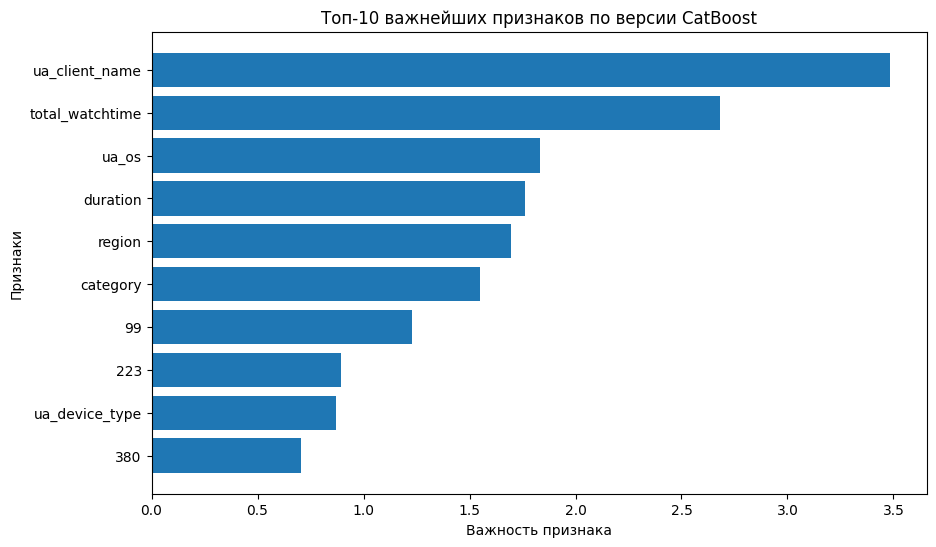

In [228]:
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostClassifier


# Получение важности признаков
feature_importances = model_age.get_feature_importance()

# Отображение имен признаков
feature_names = model_age.feature_names_

# Сортировка признаков по важности и выбор топ-10
sorted_idx = np.argsort(feature_importances)[-10:]  # Индексы топ-10 признаков

# Построение графика
plt.figure(figsize=(10, 6))
plt.barh(np.arange(10), feature_importances[sorted_idx], align='center')
plt.yticks(np.arange(10), np.array(feature_names)[sorted_idx])
plt.xlabel('Важность признака')
plt.ylabel('Признаки')
plt.title('Топ-10 важнейших признаков по версии CatBoost')
plt.show()


In [9]:
def aggregate_user_data(clean_df):
    user_embeddings = clean_df.groupby('viewer_uid')['title_embedding1'].apply(lambda x: np.mean(x.tolist(), axis=0))
    user_info = clean_df.groupby('viewer_uid').agg({

        'region': lambda x: x.mode()[0],
        'ua_device_type': lambda x: x.mode()[0],
        'ua_client_type': lambda x: x.mode()[0],
        'ua_os': lambda x: x.mode()[0],
        'ua_client_name': lambda x: x.mode()[0],
        'total_watchtime': 'sum',
        'category': lambda x: x.mode()[0],
        'duration': 'sum',

    }).reset_index()
    user_info['mean_title_embedding'] = user_embeddings.values
    return user_info

def pred(train_data,model):
    
    X_train_embeddings = np.vstack(clean_train_df['mean_title_embedding'].values)
    X_train = pd.concat([clean_train_df.drop(columns=['mean_title_embedding']), pd.DataFrame(X_train_embeddings)], axis=1)
    y_pred = model.predict(X_train)

    return   y_pred,clean_train_df




In [10]:
test_events = pd.read_csv('test_events.csv')
subm = pd.read_csv('subm.csv')

In [11]:
subm.viewer_uid

0        14416
1         5190
2         8887
3        55417
4         8980
         ...  
59999    16343
60000    47183
60001    23370
60002    12750
60003    56022
Name: viewer_uid, Length: 60004, dtype: int64

In [12]:
lis =list(subm.viewer_uid)

In [13]:
test_events

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid
0,2024-06-01 15:26:44+03:00,Udmurtiya Republic,desktop,browser,Windows,Yandex Browser,2593,video_212730,22206
1,2024-06-01 12:25:29+03:00,Adygeya Republic,smartphone,mobile app,Android,Rutube,960,video_235114,34531
2,2024-06-01 17:23:12+03:00,Astrakhan Oblast,smartphone,mobile app,Android,Rutube,4695,video_26520,25830
3,2024-06-01 15:37:37+03:00,Khakasiya Republic,smartphone,browser,Android,Chrome Mobile,2490,video_465561,14838
4,2024-06-01 21:30:11+03:00,Moscow,smartphone,mobile app,Android,Rutube,1117,video_102934,13718
...,...,...,...,...,...,...,...,...,...
587730,2024-06-30 17:33:36+03:00,Krasnodar Krai,smartphone,mobile app,Android,Rutube,2509,video_243869,23170
587731,2024-06-30 12:36:00+03:00,Moscow,tablet,browser,Android,Firefox Mobile,555,video_193920,43241
587732,2024-06-30 06:55:31+03:00,Leningradskaya Oblast',desktop,browser,Windows,Chrome,1713,video_246870,31204
587733,2024-06-30 00:16:31+03:00,Saratov Oblast,smartphone,browser,Android,Chrome Mobile,51,video_15940,40889


In [14]:
all_events = pd.read_csv('all_events.csv')
video_info = pd.read_csv('video_info_v2.csv')
train_targets = pd.read_csv('train_targets.csv')

# Объединение данных
train_data = pd.merge(test_events, train_targets, on='viewer_uid', how='left')
train_data = pd.merge(train_data, video_info, on='rutube_video_id', how='left')

# train_data =train_data.head(1000)

train_data= train_data.drop(columns=['age_class', 'sex', 'age'])


In [15]:
train_data

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,ua_client_name,total_watchtime,rutube_video_id,viewer_uid,title,category,duration,author_id
0,2024-06-01 15:26:44+03:00,Udmurtiya Republic,desktop,browser,Windows,Yandex Browser,2593,video_212730,22206,Отчаянные Домохозяйки 7 сезон 21 серия,Сериалы,2610785,1089828
1,2024-06-01 12:25:29+03:00,Adygeya Republic,smartphone,mobile app,Android,Rutube,960,video_235114,34531,Вот как воевали США во Второй мировой войне!,Разное,1080320,1009406
2,2024-06-01 17:23:12+03:00,Astrakhan Oblast,smartphone,mobile app,Android,Rutube,4695,video_26520,25830,"Бесподобный мистер Фокс (мультфильм, 2009)",Фильмы,5208416,1090779
3,2024-06-01 15:37:37+03:00,Khakasiya Republic,smartphone,browser,Android,Chrome Mobile,2490,video_465561,14838,2- Вышивальные планы на 2024г,Хобби,2556011,1017105
4,2024-06-01 21:30:11+03:00,Moscow,smartphone,mobile app,Android,Rutube,1117,video_102934,13718,"Суперниндзя. Дети, 3 выпуск",Телепередачи,8061640,1009210
...,...,...,...,...,...,...,...,...,...,...,...,...,...
587730,2024-06-30 17:33:36+03:00,Krasnodar Krai,smartphone,mobile app,Android,Rutube,2509,video_243869,23170,"ТАК СКАЗАТЬ: Фидаров – о феминизме, поствоенно...",Интервью,3524374,1022719
587731,2024-06-30 12:36:00+03:00,Moscow,tablet,browser,Android,Firefox Mobile,555,video_193920,43241,Топ-5 Игр На Телефон 2024!,Видеоигры,220550,1018241
587732,2024-06-30 06:55:31+03:00,Leningradskaya Oblast',desktop,browser,Windows,Chrome,1713,video_246870,31204,"Творческая встреча с известным писателем, публ...",Интервью,2855611,1010000
587733,2024-06-30 00:16:31+03:00,Saratov Oblast,smartphone,browser,Android,Chrome Mobile,51,video_15940,40889,СЕРИАЛЫ 2024 | ПОДБОРКА | SUDARIKOVA KATE,Сериалы,247501,1012086


In [16]:
categorical_features = [
    'region', 'ua_device_type', 'ua_client_type', 'ua_os',
    'ua_client_name', 'rutube_video_id', 'author_id', 'category'
]
categorical_mapping = {}
num_unique = {}
for col in categorical_features:
    unique_values = train_data[col].astype(str).unique().tolist()
    mapping = {val: idx for idx, val in enumerate(unique_values)}
    categorical_mapping[col] = mapping
    num_unique[col] = len(mapping) + 1  
    train_data[col] = train_data[col].astype(str).map(mapping)





train_data['cleaned_title'] = train_data['title'].apply(clean_title)
le_sex = LabelEncoder()
clean_df = generate_embeddings(train_data, batch_size=256)
clean_train_df = aggregate_user_data(clean_df)

C:\Users\Jet\anaconda3\envs\cud1\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Processing batches: 100%|██████████████████████████████████████████████████████████| 2296/2296 [05:01<00:00,  7.62it/s]


In [17]:
data_sex,client_df= pred(clean_train_df,model_sex)
data_age,client_df= pred(clean_train_df,model_age)

In [24]:
print("Размерность y_pred_sex:", data_sex.shape)
print("Размерность y_pred_age_class:", data_age.shape)
print("Размерность viewer_uid:", client_df['viewer_uid'].shape)

# Преобразование предсказаний в одномерные массивы (если они многомерные)
y_pred_sex = data_sex.flatten() if len(data_sex.shape) > 1 else data_sex
y_pred_age_class = data_age.flatten() if len(data_age.shape) > 1 else data_age
viewer_uid = client_df['viewer_uid'].values.flatten() if len(client_df['viewer_uid'].shape) > 1 else client_df['viewer_uid'].values

# Убедимся, что все массивы имеют одинаковую длину
assert len(viewer_uid) == len(y_pred_sex) == len(y_pred_age_class), "Размерности данных не совпадают!"

# Формирование датафрейма с результатами
result_df = pd.DataFrame({
    'viewer_uid': viewer_uid,  # Убедитесь, что это одномерный массив
    'sex': y_pred_sex,  # Предсказанные значения пола
    'age_class': y_pred_age_class  # Предсказанные значения возрастной категории
})

Размерность y_pred_sex: (60004,)
Размерность y_pred_age_class: (60004, 1)
Размерность viewer_uid: (60004,)


In [25]:
result_df

,viewer_uid,sex,age_class
0,0,1,3
1,1,1,3
2,2,0,2
3,3,1,2
4,4,0,1
...,...,...,...
59999,59999,0,1
60000,60000,1,2
60001,60001,1,3
60002,60002,0,1


In [26]:
age_mapping = {
    0: (9, 20),
    1: (20, 30),
    2: (30, 40),
    3: (40, 60)
}

# Применяем отображение к age_class и генерируем случайный возраст в диапазоне
result_df['age'] = result_df['age_class'].map(lambda x: np.random.randint(age_mapping[x][0], age_mapping[x][1]))
result_df = result_df[['viewer_uid', 'age', 'sex', 'age_class']]
result_df['sex'] = result_df['sex'].replace({0: 'female', 1: 'male'})
# result_df.to_csv("subm_1.csv", index=False)

In [27]:
result_df

,viewer_uid,age,sex,age_class
0,0,53,male,3
1,1,52,male,3
2,2,31,female,2
3,3,33,male,2
4,4,29,female,1
...,...,...,...,...
59999,59999,24,female,1
60000,60000,38,male,2
60001,60001,57,male,3
60002,60002,24,female,1
